In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical
import pywt

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

In [6]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [7]:
price_data = full_df[:,:,[1,2,3,4]] 

volume_data = full_df[:,:,[5,6,7,8,9]] 

price_data.shape, volume_data.shape 

((7661, 1500, 4), (7661, 1500, 5))

In [8]:
# min max normalize volume features, as they vary a lot in scale 
for i in tqdm(range(volume_data.shape[0])):
    for j in range(volume_data.shape[2]): 
        min_val = np.min(volume_data[i,:,j]) 
        max_val = np.max(volume_data[i,:,j]) 
        volume_data[i,:,j] = (volume_data[i,:,j] - min_val) / (max_val - min_val)

100%|██████████| 7661/7661 [00:00<00:00, 9353.52it/s]


# Preprocess Data

We will try a seq2seq format this time. 
Last time, we have done a seq2seq that takes in 1380 minutes of data to predict the next 120 minutes. This method does not seem to work very well. 
So instead, we will take in every 120 minutes of data and will predict 20 minutes that is 100 minutes away from the endpoint of our input data. 

So the input will be (t_1,t_2,...,t_120) and the output will be (t_220,t_221,...,t_239)  

In [9]:
N = 120
M = 20 
K = 100 
seq_len = 1500 
features_price = 4
features_volume = 5 

X_price = np.zeros(((seq_len-N-K-M)*price_data.shape[0], N, features_price))
X_volume = np.zeros(((seq_len-N-K-M)*price_data.shape[0], N, features_volume))
Y = np.zeros(((seq_len-N-K-M)*price_data.shape[0], M)) 

cnt = 0 
for i in tqdm(range(price_data.shape[0]), position = 0, leave = True): 
    j = 0 
    while j+N+K+M < seq_len: 
        X_price[cnt,:,:] = price_data[i, j:j+N, :] 
        X_volume[cnt,:,:] = volume_data[i, j:j+N, :] 
        Y[cnt,:] = price_data[i, j+N+K:j+N+K+M, 0] # get open prices as target 
        j += 1 
        cnt += 1 
        
X_price.shape, X_volume.shape, Y.shape 

100%|██████████| 7661/7661 [02:01<00:00, 63.07it/s]


((9652860, 120, 4), (9652860, 120, 5), (9652860, 20))

In [10]:
# for additional feature engineering 
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [11]:
# relative sinusoidal positional encoding 
def get_angles(pos, i, d_model): 
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model)) 
    return pos * angle_rates 

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32) 

In [12]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)
    ffn_output = Dense(node, activation = activation)(out1)
    ffn_output = Dense(node)(ffn_output)
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2 

def transformer_model(inputs, node=64, activation='relu', drop_rate=0.2, num_layers=3): 
    time_embedding = Time2Vector(N)
    bn = BatchNormalization()(inputs)
    x = time_embedding(bn)
    x = Concatenate()([bn, x])
    x = Conv1D(node, 5, activation=activation, padding='same')(x)
    x = MaxPooling1D(3)(x) 
    x = Conv1D(node*2, 5, activation=activation, padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(drop_rate)(x)
    positions = positional_encoding(x.shape[1], node*2)
    x = x * tf.math.sqrt(tf.cast(node*2, tf.float32))
    x = x + positions 
    for i in range(num_layers): 
        x = transformer_block(x, node*2, drop_rate, activation) 
        x = BatchNormalization()(x) 
    return x

def build_model(node=64, activation='relu', drop_rate=0.2, num_layers=3, num_classes=10): 
    price_inputs = Input((N, features_price))
    volume_inputs = Input((N, features_volume)) 
    
    x_p = transformer_model(price_inputs) 
    x_v = transformer_model(volume_inputs)
    
    x = Concatenate()([x_p, x_v])
    x = Dense(x_p.shape[-1], activation = 'relu')(x) 
    x = BatchNormalization()(x) 
    
    x = LSTM(M, return_sequences = False)(x) 
    x = Dropout(drop_rate)(x) 
    
    x = Dense(M, activation = 'relu')(x) 
    model = Model(inputs=[price_inputs, volume_inputs], outputs=x) 
    model.compile(loss='mape',optimizer='adam',metrics=['mae','mse','mape'])
    return model


In [13]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 4)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 4)       16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 120, 5)       20          input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
model_path = 'transformer_long_range_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit([X_price, X_volume], 
                     Y, 
                     batch_size = 512, 
                     epochs = 50, 
                     callbacks = [learning_rate_reduction, checkpoint], 
                     validation_split = 0.1)


Epoch 1/50
16968/16968 [==============================] - 1032s 59ms/step - loss: 4.6062 - mae: 0.0461 - mse: 0.0150 - mape: 4.6062 - val_loss: 1.1605 - val_mae: 0.0118 - val_mse: 4.3748e-04 - val_mape: 1.1605

Epoch 00001: val_loss improved from inf to 1.16050, saving model to transformer_long_range_epoch_001_val_1.161.h5
Epoch 2/50
16968/16968 [==============================] - 959s 57ms/step - loss: 1.0044 - mae: 0.0101 - mse: 2.8345e-04 - mape: 1.0044 - val_loss: 1.0376 - val_mae: 0.0104 - val_mse: 3.6301e-04 - val_mape: 1.0376

Epoch 00002: val_loss improved from 1.16050 to 1.03755, saving model to transformer_long_range_epoch_002_val_1.038.h5
Epoch 3/50
16968/16968 [==============================] - 974s 57ms/step - loss: 0.9726 - mae: 0.0097 - mse: 2.6290e-04 - mape: 0.9726 - val_loss: 1.5241 - val_mae: 0.0153 - val_mse: 4.4655e-04 - val_mape: 1.5241

Epoch 00003: val_loss did not improve from 1.03755
Epoch 4/50
16968/16968 [==============================] - 960s 57ms/step - los

KeyboardInterrupt: 

# Make Prediction

In [15]:
best_model = load_model('transformer_long_range_epoch_002_val_1.038.h5', custom_objects = {'Time2Vector':Time2Vector})
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 4)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 120, 5)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 4)       16          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 120, 5)       20          input_2[0][0]                    
______________________________________________________________________________________________

In [16]:
x_test_price = x_test[:,:,[1,2,3,4]] 
x_test_volume = x_test[:,:,[5,6,7,8,9]] 


In [17]:
## min-max scale volume 
for i in tqdm(range(x_test_volume.shape[0])):
    for j in range(x_test_volume.shape[2]):  
        min_val = np.min(x_test_volume[i,:,j]) 
        max_val = np.max(x_test_volume[i,:,j])
        x_test_volume[i,:,j] = (x_test_volume[i,:,j] - min_val) / (max_val - min_val) 
        
x_test_price.shape, x_test_volume.shape

100%|██████████| 535/535 [00:00<00:00, 9742.17it/s]


((535, 1380, 4), (535, 1380, 5))

In [18]:
N = 120
M = 20 
K = 100 
seq_len = 1500 
features_price = 4
features_volume = 5 
X_test_price = np.zeros((6*x_test.shape[0],N,features_price)) 
X_test_volume = np.zeros((6*x_test.shape[0],N,features_volume)) 



cnt = 0 
for j in tqdm(range(x_test.shape[0]), position = 0, leave=True): 
    for i in range(1160, 1260, M): 
        X_test_price[cnt,:,:] = x_test_price[j,i:i+N,:]  
        X_test_volume[cnt,:,:] = x_test_volume[j,i:i+N,:]
        cnt += 1 

X_test_price.shape, X_test_volume.shape 


100%|██████████| 535/535 [00:00<00:00, 31165.14it/s]


((3210, 120, 4), (3210, 120, 5))

In [19]:
predicted = best_model.predict([X_test_price, X_test_volume])
predicted = predicted.reshape((-1,120))
predicted.shape


(535, 120)

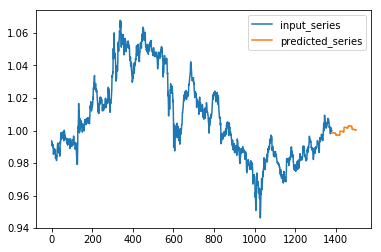

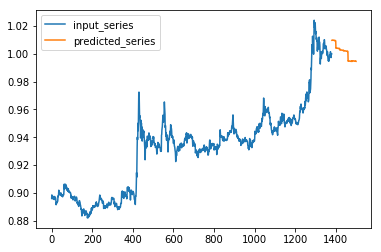

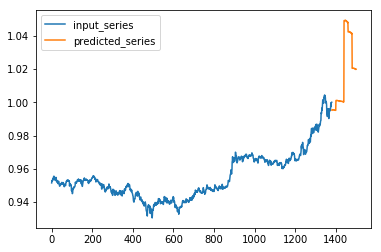

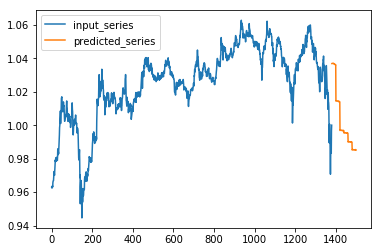

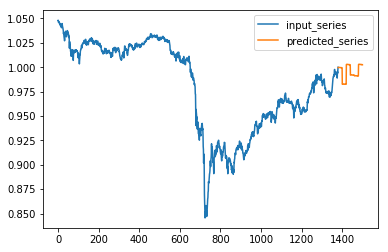

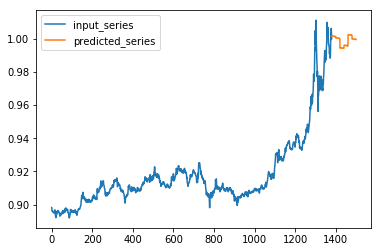

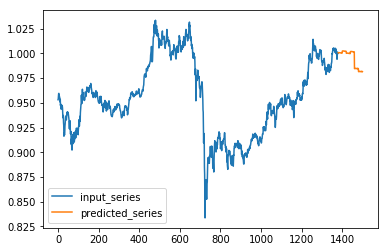

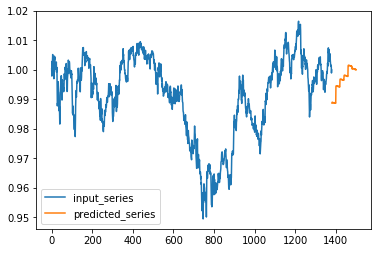

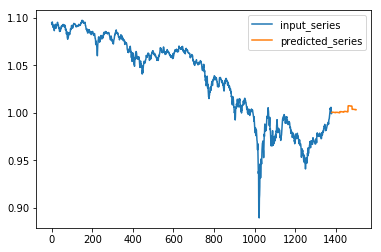

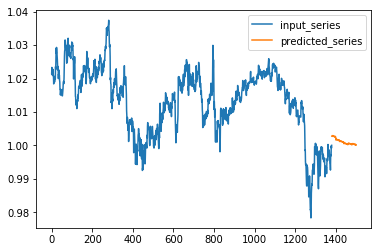

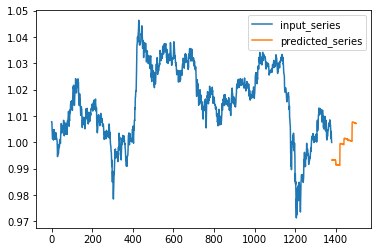

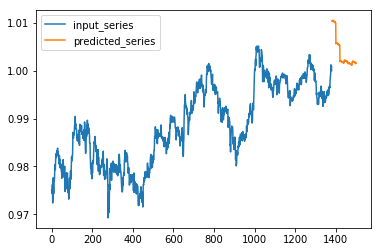

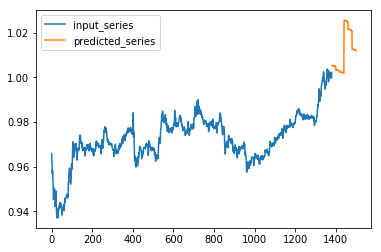

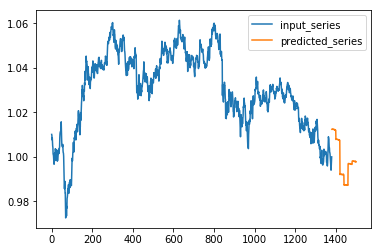

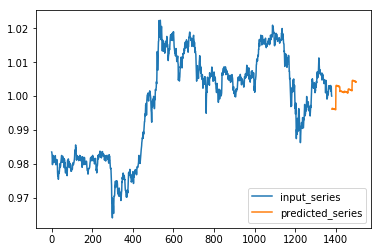

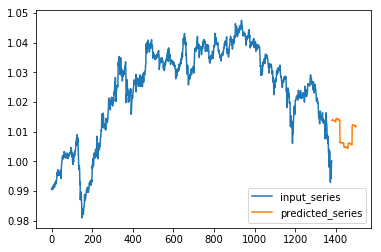

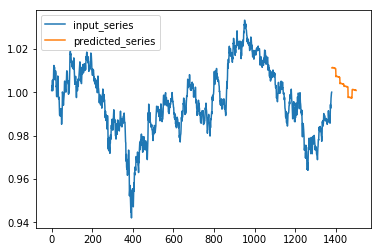

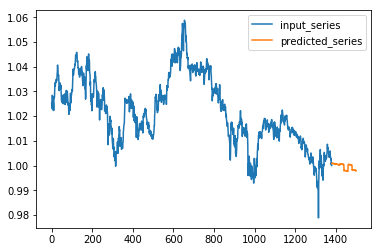

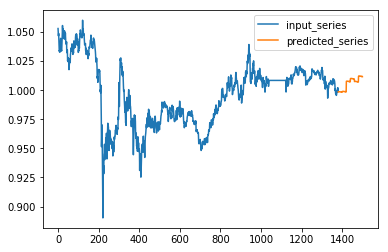

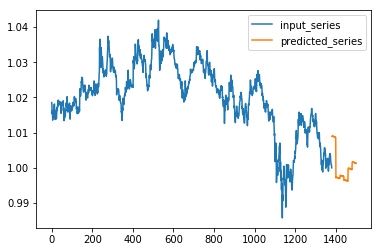

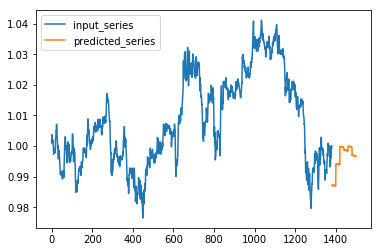

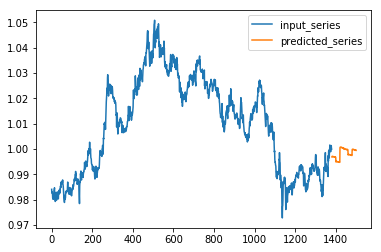

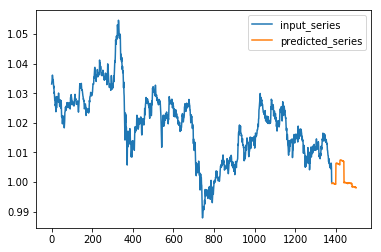

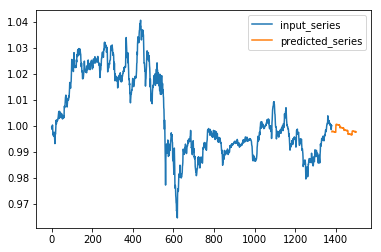

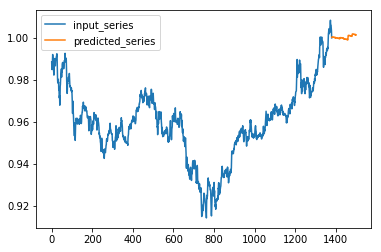

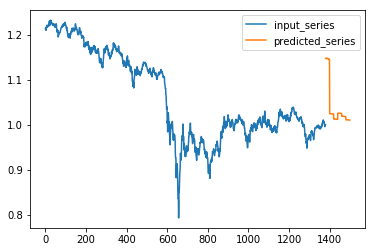

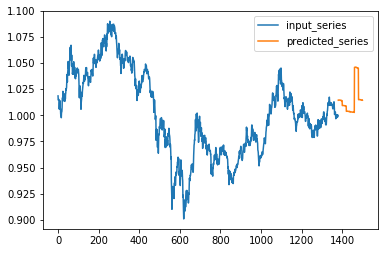

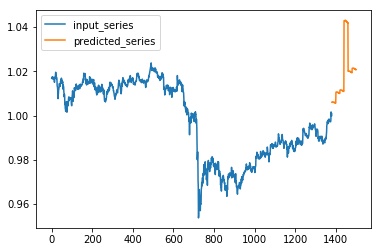

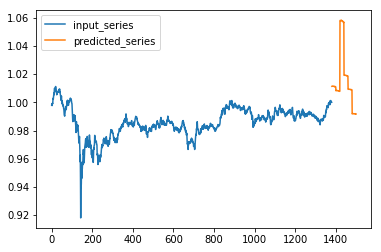

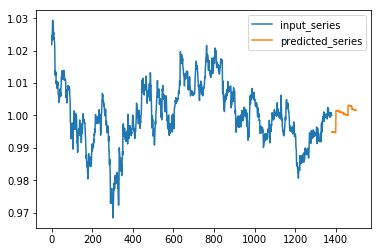

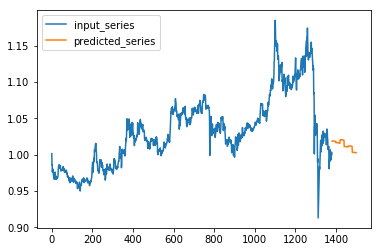

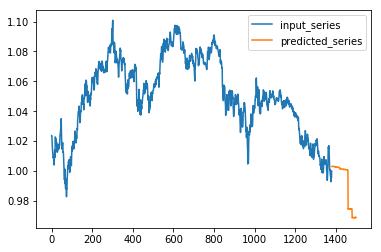

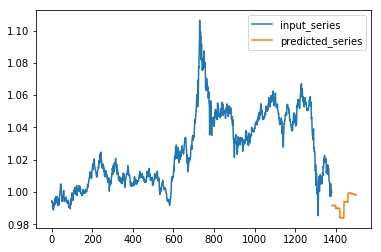

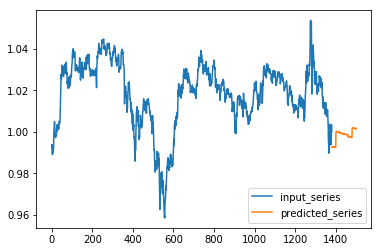

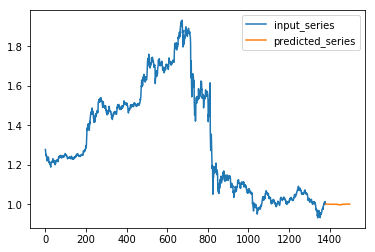

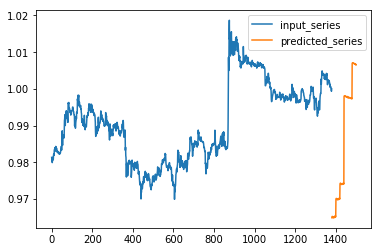

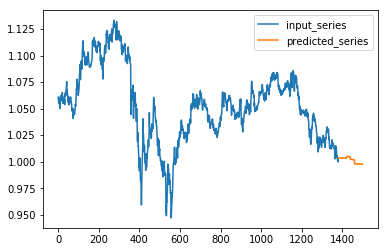

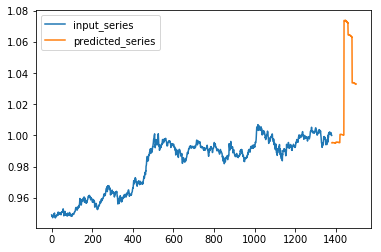

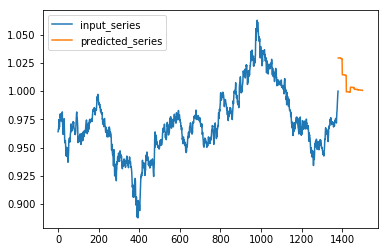

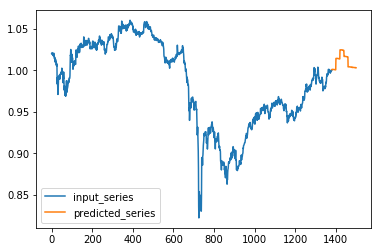

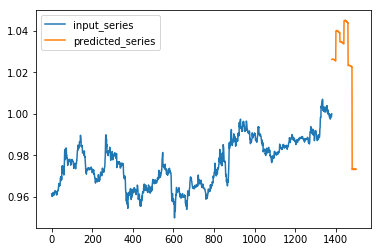

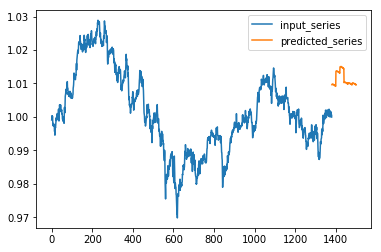

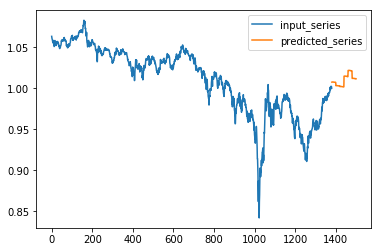

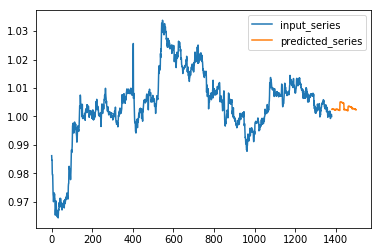

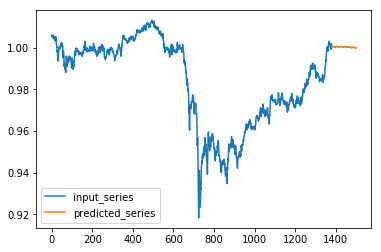

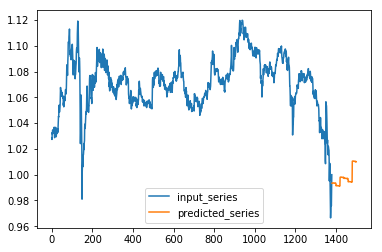

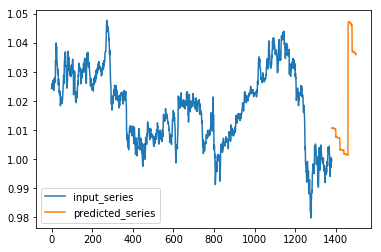

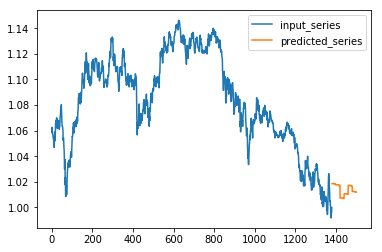

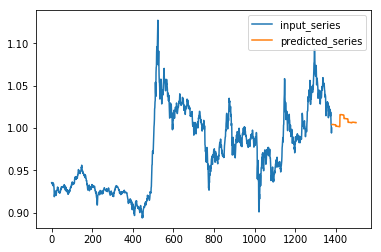

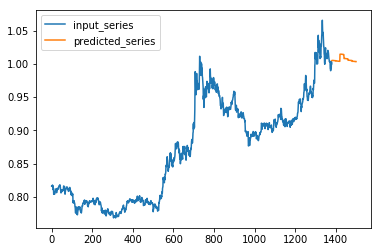

In [20]:
for i in range(50): 
    plt.plot() 
    plot_predicted_series(x_test_price[i,:,0], predicted[i,:]) 
    plt.show() 



In [21]:
x_test_open = x_test[:,:,1] # open prices 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    start_price = x_test_open[i,-1] 
    if predicted[i,0] > start_price:
        diff = predicted[i,0] - start_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < start_price:  
        diff = start_price - predicted[i,0] 
        predicted[i,:] += diff 

100%|██████████| 535/535 [00:00<00:00, 113228.01it/s]


In [23]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('long_partial_2.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4024.49it/s]


In [24]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.766667,85
1,7662,0.083333,5
2,7663,0.941667,65
3,7664,0.083333,5
4,7665,0.425000,105
...,...,...,...
530,8191,0.500000,18
531,8192,0.500000,18
532,8193,0.500000,18
533,8194,0.466667,18


In [25]:
df1 = pd.read_csv('max_ensemble.csv') 
df2 = pd.read_csv('long_partial_2.csv') 

df1

,sample_id,buy_quantity,sell_time
0,7661,0.875000,98
1,7662,1.000000,54
2,7663,0.975000,84
3,7664,0.341667,23
4,7665,0.850000,119
...,...,...,...
530,8191,0.116667,9
531,8192,0.158333,113
532,8193,0.875000,73
533,8194,0.133333,14


In [26]:
df2

,sample_id,buy_quantity,sell_time
0,7661,0.766667,85
1,7662,0.083333,5
2,7663,0.941667,65
3,7664,0.083333,5
4,7665,0.425000,105
...,...,...,...
530,8191,0.500000,18
531,8192,0.500000,18
532,8193,0.500000,18
533,8194,0.466667,18


In [28]:
bq = [] 
st = [] 

df1_bq = df1['buy_quantity'] 
df1_st = df1['sell_time'] 

df2_bq = df2['buy_quantity'] 
df2_st = df2['sell_time'] 


for i in tqdm(range(len(df1_bq))): 
    if df1_bq[i] > df2_bq[i]: 
        bq.append(df1_bq[i])
        st.append(df1_st[i]) 
    else: 
        bq.append(df2_bq[i]) 
        st.append(df2_st[i])

100%|██████████| 535/535 [00:00<00:00, 60867.81it/s]


In [30]:
submission.iloc[:,1] = bq 
submission.iloc[:,2] = st

In [31]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.875000,98
1,7662,1.000000,54
2,7663,0.975000,84
3,7664,0.341667,23
4,7665,0.850000,119
...,...,...,...
530,8191,0.500000,18
531,8192,0.500000,18
532,8193,0.875000,73
533,8194,0.466667,18


In [32]:
submission.to_csv('max_ensemble_just_testing.csv',index=False)